## Conditional Probability Plots - Attempt 3
## Making these plots PDFs instead of histograms

**Do some conditional probability plots**
* for SW > 600 w/m2, 
    * what fraction of images in each 1 degree wide T bin unload vs stay
        * plotted as, T vs Prob_unload(T)
* for SW between 400-600 W/m2, repeat 

And then by wind <br>
Then say for all T<0, what probability unloads for each 100 W/m^2 wide solar bin? Etc. 

In [2]:
# import packages 
%matplotlib widget

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

# interactive plotting
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots # adding for subplots
import plotly.figure_factory as ff

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

## Open met data and classifications
**Make them into a single df** 

In [57]:
# Open micro met station
opn  = pd.read_csv("/Users/Lumbr/OneDrive - UW/Documents/Washington/UnloadingRegimes/MetStations/Cleaned/opnc_hcass.csv")
opn['datetime'] = pd.to_datetime(opn['datetime'])

# Laret Station Data 
laretstation = pd.read_csv("/Users/Lumbr/OneDrive - UW/Documents/Washington/UnloadingRegimes/MetStations/LaretStation/CSV/laretstation.csv")
laretstation.index = pd.DatetimeIndex(laretstation['datetime'])
laretstation.drop(columns=['datetime'], inplace=True)

# Open observations classifications 
obs = pd.read_csv("/Users/Lumbr/OneDrive - UW/Documents/Washington/UnloadingRegimes/Excel/Datetime/datetimeformat_ccg_classifications_only_cutdates_sunlightminus1.csv")
obs['datetime'] = pd.to_datetime(obs['datetime'])
obs.dropna(axis=0, how='all', inplace=True) #removing row is entire row is NAN #careful with this, without datetime a lot gets removed

# Merge into 1 df
opndf = pd.merge(opn, obs, how='outer', on='datetime')
opndf.index = pd.DatetimeIndex(opndf['datetime'])

stationdf = pd.merge(laretstation, obs, how='outer', on='datetime')
stationdf.index = pd.DatetimeIndex(stationdf['datetime'])

**Add a symbol to the sunlit classifications**
- E and Eminus 1 

In [58]:
# Create symbols for sunlit or not 
opndf['Esymbol']=np.nan  
opndf['Eminus1symbol']=np.nan  

# open triangle for cloudy, diamond for sunny, open x circle for no radiation data
opndf['Esymbol'].mask(opndf['E'] == 0., 105, inplace=True) # this is working without fillna
opndf['Esymbol'].mask(opndf['E'] == 1., 2, inplace=True)  
opndf['Eminus1symbol'].mask(opndf['Eminus1'] == 0., 105, inplace=True) # this is working without fillna
opndf['Eminus1symbol'].mask(opndf['Eminus1'] == 1., 2, inplace=True)  

# then fillna with 128 for circle with x through it 
opndf['Esymbol'] = opndf['Esymbol'].fillna(128) 
opndf['Eminus1symbol'] = opndf['Eminus1symbol'].fillna(128) 

# Create symbols for sunlit or not 
stationdf['Esymbol']=np.nan  
stationdf['Eminus1symbol']=np.nan  

# open triangle for cloudy, diamond for sunny, open x circle for no radiation data
stationdf['Esymbol'].mask(stationdf['E'] == 0., 105, inplace=True) # this is working without fillna
stationdf['Esymbol'].mask(stationdf['E'] == 1., 2, inplace=True)  
stationdf['Eminus1symbol'].mask(stationdf['Eminus1'] == 0., 105, inplace=True) # this is working without fillna
stationdf['Eminus1symbol'].mask(stationdf['Eminus1'] == 1., 2, inplace=True)  

# then fillna with 128 for circle with x through it 
stationdf['Esymbol'] = stationdf['Esymbol'].fillna(128) 
stationdf['Eminus1symbol'] = stationdf['Eminus1symbol'].fillna(128) 

**Create seperate df for only snow in canopy timesteps**

In [59]:
opndf_unload = opndf.copy(deep=True)
opndf_unload = opndf_unload.dropna(axis=0, how='any', subset=['CD'])

sdf_unload = stationdf.copy(deep=True)
sdf_unload = sdf_unload.dropna(axis=0, how='any', subset=['CD'])

In [62]:
# MICRO MET STATION DATA: OPEN SITE
opndf_unload.dropna(inplace=True) ## BE CAREFUL WITH THIS

opndf_unload['Classification'] = opndf_unload.CD.copy(deep=True)

opndf_unload.Classification.mask(opndf_unload.Classification == 0, "Snow Unloading", inplace=True)
opndf_unload.Classification.mask(opndf_unload.Classification == 1, "Snow Staying in the Canopy", inplace=True)

snowstaydf   = opndf_unload.where(opndf_unload.CD == 1).dropna() # where CD == 1, meaning Snow Staying, make that snowstaydf
snowunloaddf = opndf_unload.where(opndf_unload.CD == 0).dropna() # where CD == 0, meaning Snow Unloading, make that snowunloaddf

# LARET STATION DATA 
# sdf_unload.dropna(inplace=True) 

sdf_unload['Classification'] = sdf_unload.CD.copy(deep=True)

# To have the same variable names as Laret micro station data 
sdf_unload['AirTC_Avg'] = sdf_unload.ta_1.copy(deep=True)
sdf_unload['WS_ms_Avg'] = sdf_unload.vw_1.copy(deep=True)
sdf_unload['SWR_Avg'] = sdf_unload.iswr.copy(deep=True)


sdf_unload.Classification.mask(sdf_unload.Classification == 0, "Snow Unloading", inplace=True)
sdf_unload.Classification.mask(sdf_unload.Classification == 1, "Snow Staying in the Canopy", inplace=True)

snowstaysdf   = sdf_unload.where(sdf_unload.CD == 1).dropna() # where CD == 1, meaning Snow Staying, make that snowstaydf
snowunloadsdf = sdf_unload.where(sdf_unload.CD == 0).dropna() # where CD == 0, meaning Snow Unloading, make that snowunloaddf

In [68]:
print(len(sdf_unload), len(opndf_unload))

363 279


In [67]:
print(len(snowstaysdf), len(snowunloadsdf), len(snowstaydf), len(snowunloaddf))

73 48 177 102


-------------------------

In [63]:
## Define some plotting constants for easier coding 
plt.close('all')

# Colors
colornosnow = '#D2B48C' # nice tan
colorsnow = '#7dcfd4' # slightly desaturated cyan
colorsnowunload = '#1F15D5' # bright, deep blue 
colorsunny = '#E4E44A' # trying a little less bright 

# Grouped Colors
colors = [colorsnow, colorsnowunload] # my colors 

# Names
namesnow = 'Snow Staying'
namesnowunload = 'Snow Unloading'
group_labels = ['Snow Staying', 'Snow Unloading']

nametemp = "Air Temperature (C)"
nameSW = "Shortwave (W/m2)"
namewind = "Wind Speed (m/s)"

# Hist defaults
bintemp = [2,2]
binSW = [100,100]
binwind = [1,1]

In [8]:
def histpdf(x1, x2, binsize, kdeornorm, title, axistitle, showhist):
    # define data 
    hist_data = [x1, x2]

    # set plot constants 
    group_labels = ['Snow Staying', 'Snow Unloading']
    bin_sizes = binsize
    colors = [colorsnow, colorsnowunload] # my colors 

    # Create distplot 
    fig = ff.create_distplot(hist_data, group_labels, bin_size=bin_sizes, colors=colors, 
                             show_hist=showhist, show_rug=True,
                             curve_type=kdeornorm) # override deafult "kde" curve.. look inot this 

    fig.add_vline(x=np.mean(x1), line_color=colorsnow, line_dash='dash')
    fig.add_vline(x=np.mean(x2), line_color=colorsnowunload, line_dash='dash')

    fig.add_vrect(x0=np.mean(x1), x1=np.mean(x2), fillcolor="LightSalmon", opacity=0.2, layer="below", line_width=0)

    fig.update_layout(title=title, width=900, height=600, yaxis_title="probability density", xaxis_title=axistitle)

    fig.show()

# *Conditional Probability Analysis* - PDFs

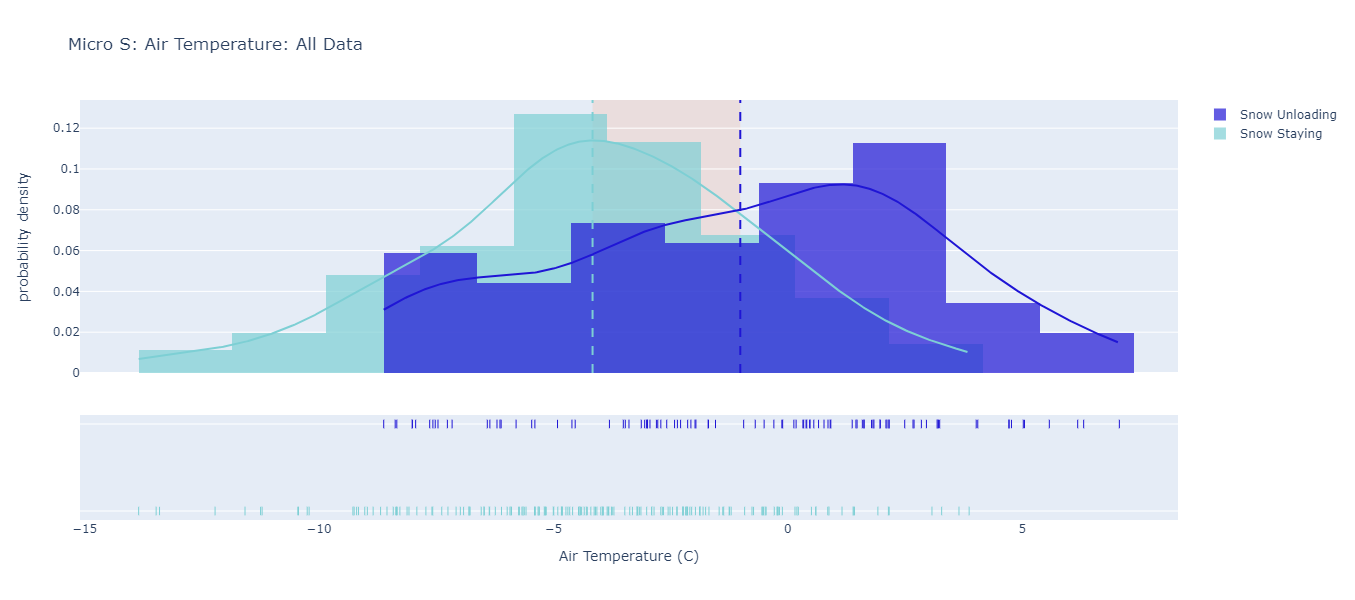

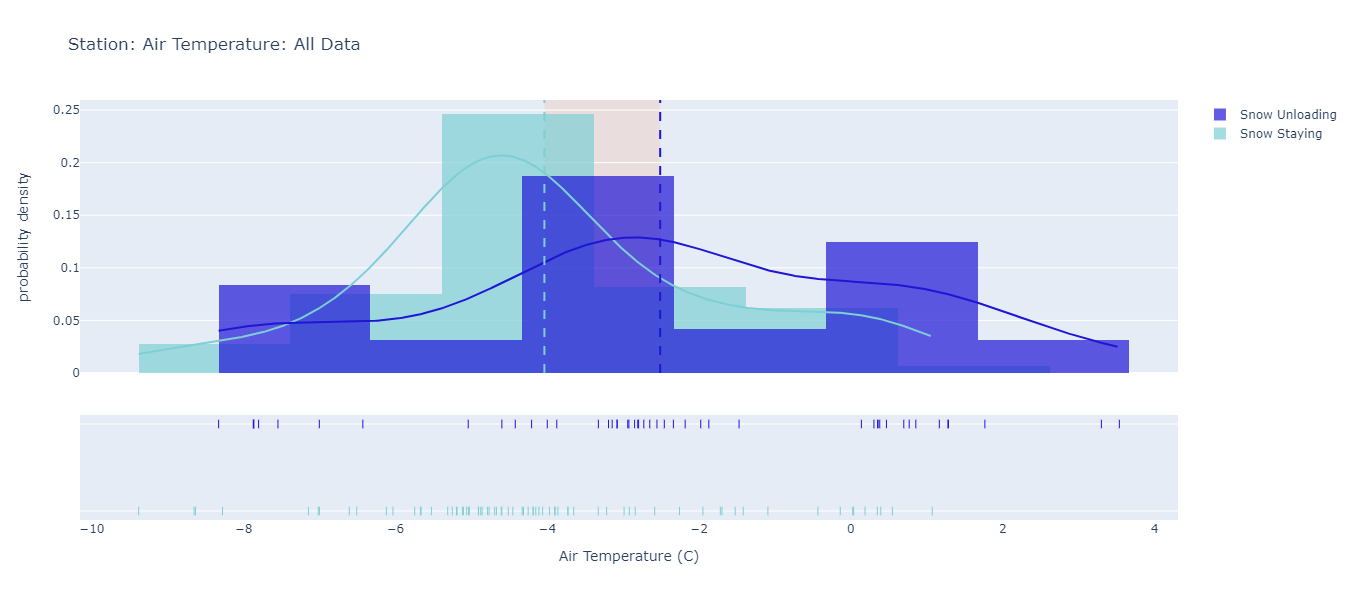

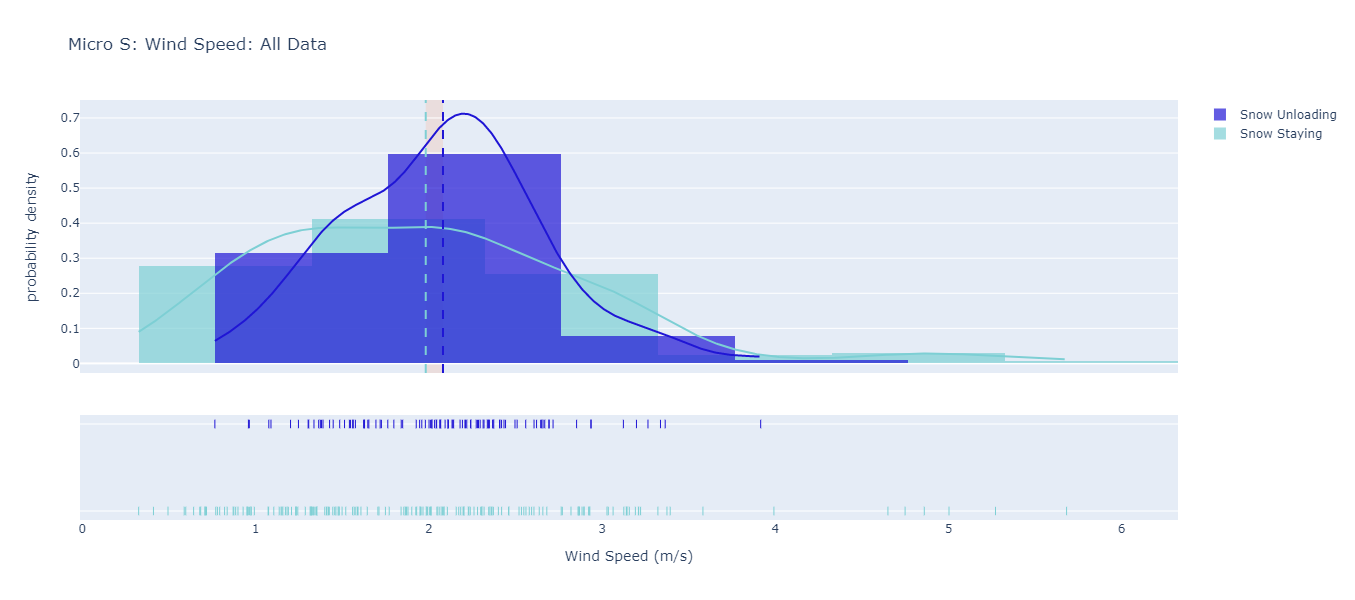

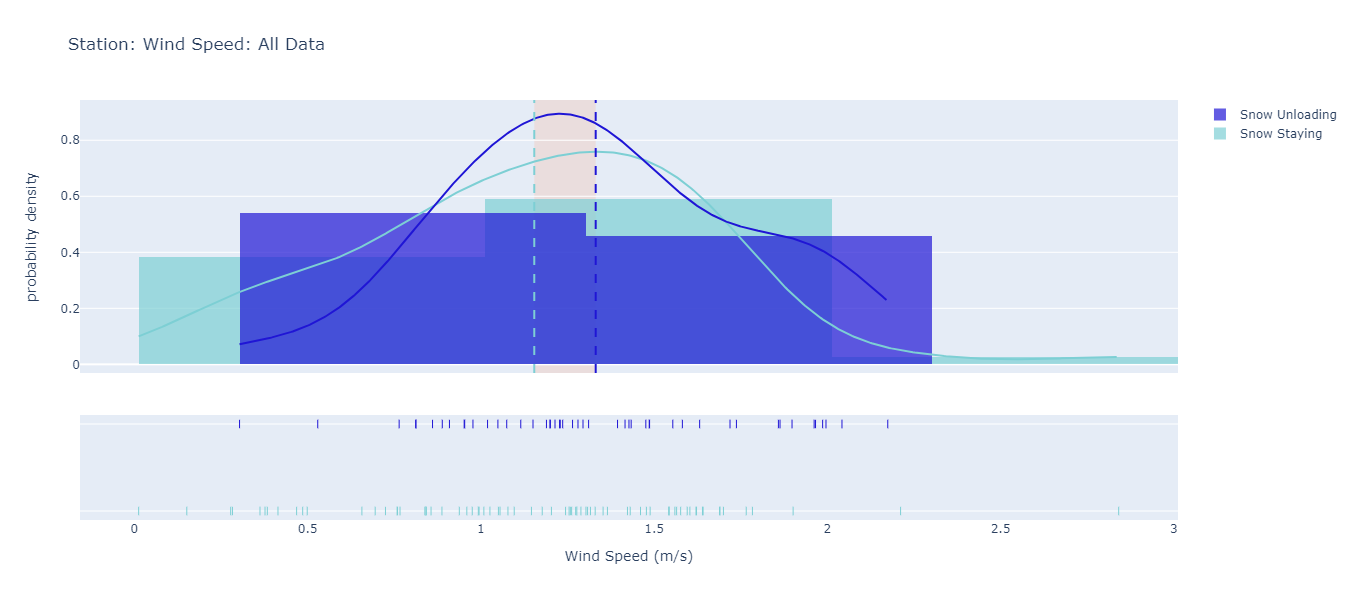

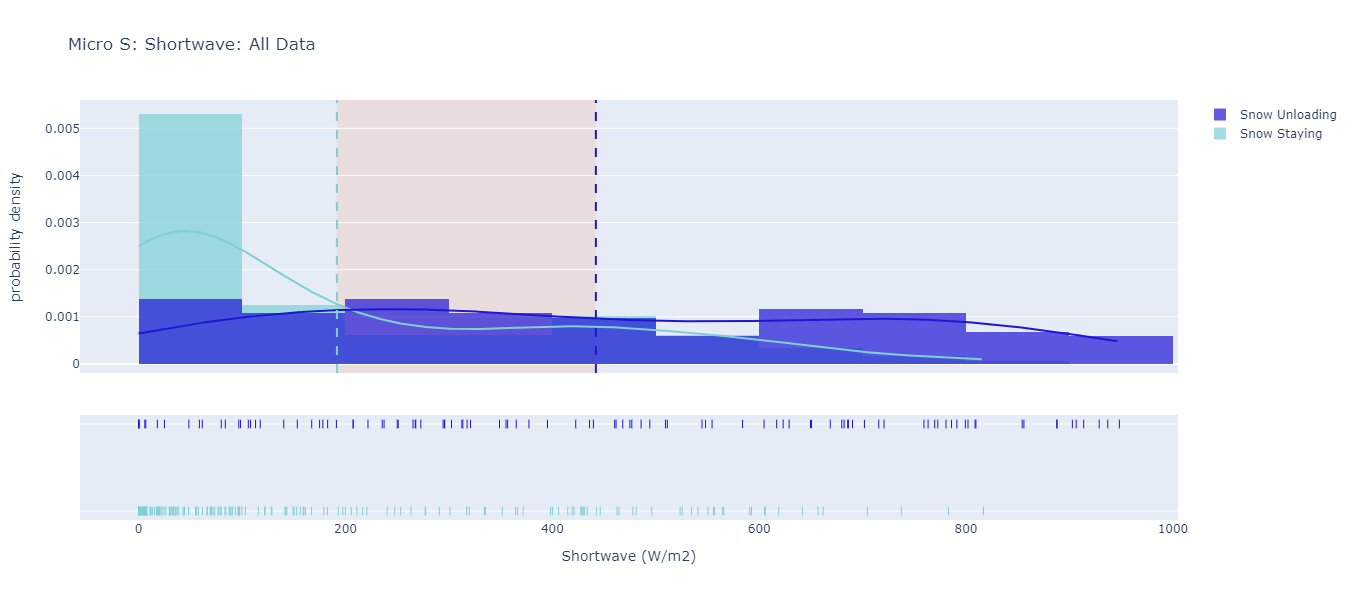

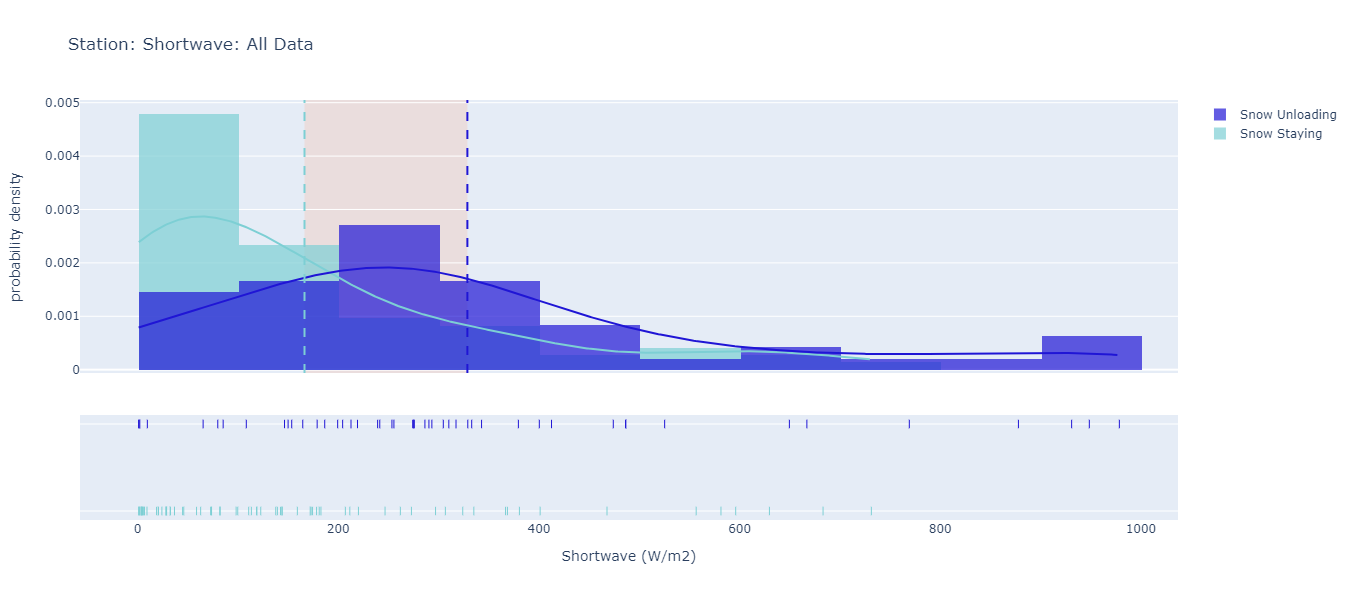

In [64]:
histpdf(snowstaydf.AirTC_Avg, snowunloaddf.AirTC_Avg, bintemp, 'kde', 'Micro S: Air Temperature: All Data', nametemp, True)
histpdf(snowstaysdf.AirTC_Avg, snowunloadsdf.AirTC_Avg, bintemp, 'kde', 'Station: Air Temperature: All Data', nametemp, True)

histpdf(snowstaydf.WS_ms_Avg, snowunloaddf.WS_ms_Avg, binwind, 'kde', 'Micro S: Wind Speed: All Data', namewind, True)
histpdf(snowstaysdf.WS_ms_Avg, snowunloadsdf.WS_ms_Avg, binwind, 'kde', 'Station: Wind Speed: All Data', namewind, True)

histpdf(snowstaydf.SWR_Avg, snowunloaddf.SWR_Avg, binSW, 'kde', 'Micro S: Shortwave: All Data', nameSW, True)
histpdf(snowstaysdf.SWR_Avg, snowunloadsdf.SWR_Avg, binSW, 'kde', 'Station: Shortwave: All Data', nameSW, True)

## Creating new dataframes and classifying them based on categories 
Shortwave
- **dfSW600**: SW > 600
- **dfSW400600**: 400 < SW < 600
- **dfSW400**: SW < 400

Temperature
- **dfTg0**: T > 0 
- **dfTl0**: T < 0 

In [15]:
# Create copies of the df we want, and then going to classify it by SW threshold
dfSW600 =    opndf_unload.copy(deep=True) # SW > 600
dfSW400600 = opndf_unload.copy(deep=True) # SW between 400-600
dfSW400 =    opndf_unload.copy(deep=True) # SW < 400

# Create for temperature threshold 
dfTg0 =    opndf_unload.copy(deep=True) # Temp g(greater) 0
dfTl0 =    opndf_unload.copy(deep=True) # Temp l(less)    0 

# Creating df with only SW > 600
dfSW600.mask(dfSW600.SWR_Avg < 600, inplace=True) # we want where SW > 600, else nan
dfSW600.dropna(inplace=True) # and drop all nan... 
dfSW600stay   = dfSW600.where(dfSW600.CD == 1).dropna()
dfSW600unload = dfSW600.where(dfSW600.CD == 0).dropna()

# Creating df with onyl 400 < SW < 600
dfSW400600.mask(dfSW400600.SWR_Avg > 600, inplace=True) # we want where SW < 600, 
dfSW400600.mask(dfSW400600.SWR_Avg < 400, inplace=True) # and SW > 400, else nan
dfSW400600.dropna(inplace=True) # and drop all nan... 
dfSW400600stay   = dfSW400600.where(dfSW400600.CD == 1).dropna()
dfSW400600unload = dfSW400600.where(dfSW400600.CD == 0).dropna()

# Creating df with SW < 400
dfSW400.mask(dfSW400.SWR_Avg > 400, inplace=True) # we want where SW < 400, else nan
dfSW400.dropna(inplace=True) # and drop all nan...
dfSW400stay   = dfSW400.where(dfSW400.CD == 1).dropna()
dfSW400unload = dfSW400.where(dfSW400.CD == 0).dropna()

# Create df with T > 0 
dfTg0.mask(dfTg0.AirTC_Avg < 0, inplace=True) # we want where T > 0, else nan
dfTg0.dropna(inplace=True) 
dfTg0stay   = dfTg0.where(dfTg0.CD == 1).dropna()
dfTg0unload = dfTg0.where(dfTg0.CD == 0).dropna()

# Create df with T < 0 
dfTl0.mask(dfTl0.AirTC_Avg > 0, inplace=True) # we want where T < 0, else nan 
dfTl0.dropna(inplace=True)
dfTl0stay   = dfTl0.where(dfTl0.CD == 1).dropna()
dfTl0unload = dfTl0.where(dfTl0.CD == 0).dropna()

In [16]:
# Create copies of the df we want, and then going to classify it by SW threshold
sdfSW600 =    sdf_unload.copy(deep=True) # SW > 600
sdfSW400600 = sdf_unload.copy(deep=True) # SW between 400-600
sdfSW400 =    sdf_unload.copy(deep=True) # SW < 400

# Create for temperature threshold 
sdfTg0 =    sdf_unload.copy(deep=True) # Temp g(greater) 0
sdfTl0 =    sdf_unload.copy(deep=True) # Temp l(less)    0 

# Creating df with only SW > 600
sdfSW600.mask(sdfSW600.SWR_Avg < 600, inplace=True) # we want where SW > 600, else nan
sdfSW600.dropna(inplace=True) # and drop all nan... 
sdfSW600stay   = sdfSW600.where(sdfSW600.CD == 1).dropna()
sdfSW600unload = sdfSW600.where(sdfSW600.CD == 0).dropna()

# Creating df with onyl 400 < SW < 600
sdfSW400600.mask(sdfSW400600.SWR_Avg > 600, inplace=True) # we want where SW < 600, 
sdfSW400600.mask(sdfSW400600.SWR_Avg < 400, inplace=True) # and SW > 400, else nan
sdfSW400600.dropna(inplace=True) # and drop all nan... 
sdfSW400600stay   = sdfSW400600.where(sdfSW400600.CD == 1).dropna()
sdfSW400600unload = sdfSW400600.where(sdfSW400600.CD == 0).dropna()

# Creating df with SW < 400
sdfSW400.mask(sdfSW400.SWR_Avg > 400, inplace=True) # we want where SW < 400, else nan
sdfSW400.dropna(inplace=True) # and drop all nan...
sdfSW400stay   = sdfSW400.where(sdfSW400.CD == 1).dropna()
sdfSW400unload = sdfSW400.where(sdfSW400.CD == 0).dropna()

# Create df with T > 0 
sdfTg0.mask(sdfTg0.AirTC_Avg < 0, inplace=True) # we want where T > 0, else nan
sdfTg0.dropna(inplace=True) 
sdfTg0stay   = sdfTg0.where(sdfTg0.CD == 1).dropna()
sdfTg0unload = sdfTg0.where(sdfTg0.CD == 0).dropna()

# Create df with T < 0 
sdfTl0.mask(sdfTl0.AirTC_Avg > 0, inplace=True) # we want where T < 0, else nan 
sdfTl0.dropna(inplace=True)
sdfTl0stay   = sdfTl0.where(sdfTl0.CD == 1).dropna()
sdfTl0unload = sdfTl0.where(sdfTl0.CD == 0).dropna()

## Air Temperature by Classification
### SW thresholds

In [23]:
# histpdf(dfSW600stay.AirTC_Avg, dfSW600unload.AirTC_Avg, [1,1], 'kde', 'Micro S: Air Temperature: SW > 600', nametemp, False)
# histpdf(sdfSW600stay.AirTC_Avg, sdfSW600unload.AirTC_Avg, [1,1], 'kde', 'Station: Air Temperature: SW > 600', nametemp, False)

# histpdf(dfSW400600stay.AirTC_Avg, dfSW400600unload.AirTC_Avg, [1,1], 'kde', 'Micro S: Air Temperature: 400 < SW < 600', nametemp, False)
# histpdf(sdfSW400600stay.AirTC_Avg, sdfSW400600unload.AirTC_Avg, [1,1], 'kde', 'Station: Air Temperature: 400 < SW < 600', nametemp, False)

# histpdf(dfSW400stay.AirTC_Avg, dfSW400unload.AirTC_Avg, [1,1], 'kde', 'Micro S: Air Temperature: SW < 400', nametemp, False)
# histpdf(sdfSW400stay.AirTC_Avg, sdfSW400unload.AirTC_Avg, [1,1], 'kde', 'Station: Air Temperature: SW < 400', nametemp, False)

## Wind Speed by Classification, 
### SW threshold

In [24]:
# histpdf(dfSW600stay.WS_ms_Avg, dfSW600unload.WS_ms_Avg, [1,1], 'kde', 'Micro S: Wind Speed: SW > 600', namewind, False)
# histpdf(sdfSW600stay.WS_ms_Avg, sdfSW600unload.WS_ms_Avg, [1,1], 'kde', 'Station: Wind Speed: SW > 600', namewind, False)

# histpdf(dfSW400600stay.WS_ms_Avg, dfSW400600unload.WS_ms_Avg, [1,1], 'kde', 'Micro S: Wind Speed: 400 < SW < 600', namewind, False)
# histpdf(sdfSW400600stay.WS_ms_Avg, sdfSW400600unload.WS_ms_Avg, [1,1], 'kde', 'Station: Wind Speed: 400 < SW < 600', namewind, False)

# histpdf(dfSW400stay.WS_ms_Avg, dfSW400unload.WS_ms_Avg, [1,1], 'kde', 'Micro S: Wind Speed: SW < 400', namewind, False)
# histpdf(sdfSW400stay.WS_ms_Avg, sdfSW400unload.WS_ms_Avg, [1,1], 'kde', 'Station: Wind Speed: SW < 400', namewind, False)

## SW by Classification
### For air temperature threshold

In [26]:
# histpdf(dfTg0stay.SWR_Avg, dfTg0unload.SWR_Avg, [100,100], 'kde', 'Micro S: Shortwave: T > 0', nameSW, False)
# histpdf(sdfTg0stay.SWR_Avg, sdfTg0unload.SWR_Avg, [100,100], 'kde', 'Station: Shortwave: T > 0', nameSW, False)

# histpdf(dfTl0stay.SWR_Avg, dfTl0unload.SWR_Avg, [100,100], 'kde', 'Micro S: Shortwave: T < 0', nameSW, False)
# histpdf(sdfTl0stay.SWR_Avg, sdfTl0unload.SWR_Avg, [100,100], 'kde', 'Station: Shortwave: T < 0', nameSW, False)

## Wind by Classification
### Air Temperature Threshold 

In [49]:
# histpdf(dfTg0stay.WS_ms_Avg, dfTg0unload.WS_ms_Avg, [1,1], 'kde', 'Micro S: Wind Speed: T > 0', namewind, False)
# histpdf(sdfTg0stay.WS_ms_Avg, sdfTg0unload.WS_ms_Avg, [1,1], 'kde', 'Station: Wind Speed: T > 0', namewind, False)

# histpdf(dfTl0stay.WS_ms_Avg, dfTl0unload.WS_ms_Avg, [1,1], 'kde', 'Micro S: Wind Speed: T < 0', namewind, False)
# histpdf(sdfTl0stay.WS_ms_Avg, sdfTl0unload.WS_ms_Avg, [1,1], 'kde', 'Station: Wind Speed: T < 0', namewind, False)

# Statistics 

In [28]:
# stat packages 
import scipy.stats as stats
from scipy.stats import norm # create normal distribution from dataset 
from scipy.stats import chisquare #Calculate a one-way chi-square test.
from scipy.stats import chi2_contingency #Chi-square test of independence of variables in a contingency table.

## T-Statistic

#### All Full Dataset

In [35]:
stats.ttest_ind(snowunloadsdf['AirTC_Avg'], snowstaysdf['AirTC_Avg'])

Ttest_indResult(statistic=3.118091666344378, pvalue=0.0022830683438460763)

In [36]:
stats.ttest_ind(snowunloadsdf['SWR_Avg'], snowstaysdf['SWR_Avg'])

Ttest_indResult(statistic=4.139038877615681, pvalue=6.541636072408308e-05)

In [37]:
stats.ttest_ind(snowunloadsdf['WS_ms_Avg'], snowstaysdf['WS_ms_Avg'])

Ttest_indResult(statistic=2.0120399398084894, pvalue=0.04647422210408621)

### Shortwave Thresholded Data
**SW > 600**

In [38]:
stats.ttest_ind(sdfSW600stay['AirTC_Avg'], sdfSW600unload['AirTC_Avg'])

Ttest_indResult(statistic=-2.7938800368674483, pvalue=0.02341776622203738)

In [39]:
stats.ttest_ind(sdfSW600stay['WS_ms_Avg'], sdfSW600unload['WS_ms_Avg'])

Ttest_indResult(statistic=0.6307770576795835, pvalue=0.5457801289358664)

**400 < SW < 600**

In [40]:
stats.ttest_ind(sdfSW400600stay['AirTC_Avg'], sdfSW400600unload['AirTC_Avg'])

Ttest_indResult(statistic=0.38598822980441916, pvalue=0.7084712814163323)

In [41]:
stats.ttest_ind(sdfSW400600stay['WS_ms_Avg'], sdfSW400600unload['WS_ms_Avg'])

Ttest_indResult(statistic=-0.6324937482303025, pvalue=0.5427970948595804)

**SW < 400**

In [42]:
stats.ttest_ind(sdfSW400stay['AirTC_Avg'], sdfSW400unload['AirTC_Avg'])

Ttest_indResult(statistic=-2.071566698416086, pvalue=0.040932970337104926)

In [43]:
stats.ttest_ind(sdfSW400stay['WS_ms_Avg'], sdfSW400unload['WS_ms_Avg'])

Ttest_indResult(statistic=-1.440503521058081, pvalue=0.15291226578642803)

### Temperature Thresholded Data 
**T>0**

In [44]:
stats.ttest_ind(sdfTg0stay['SWR_Avg'], sdfTg0unload['SWR_Avg'])

Ttest_indResult(statistic=-0.7552885716210007, pvalue=0.4588789705653662)

In [45]:
stats.ttest_ind(sdfTg0stay['WS_ms_Avg'], sdfTg0unload['WS_ms_Avg'])

Ttest_indResult(statistic=-0.2454063735879905, pvalue=0.8086424193024329)

**T<0**

In [46]:
stats.ttest_ind(sdfTl0stay['SWR_Avg'], sdfTl0unload['SWR_Avg'])

Ttest_indResult(statistic=-3.8780356399467615, pvalue=0.00019174290988042313)

In [48]:
stats.ttest_ind(sdfTl0stay['WS_ms_Avg'], sdfTl0unload['WS_ms_Avg'])

Ttest_indResult(statistic=-2.609414450040742, pvalue=0.010505857482443558)

# Scatter Matrix 

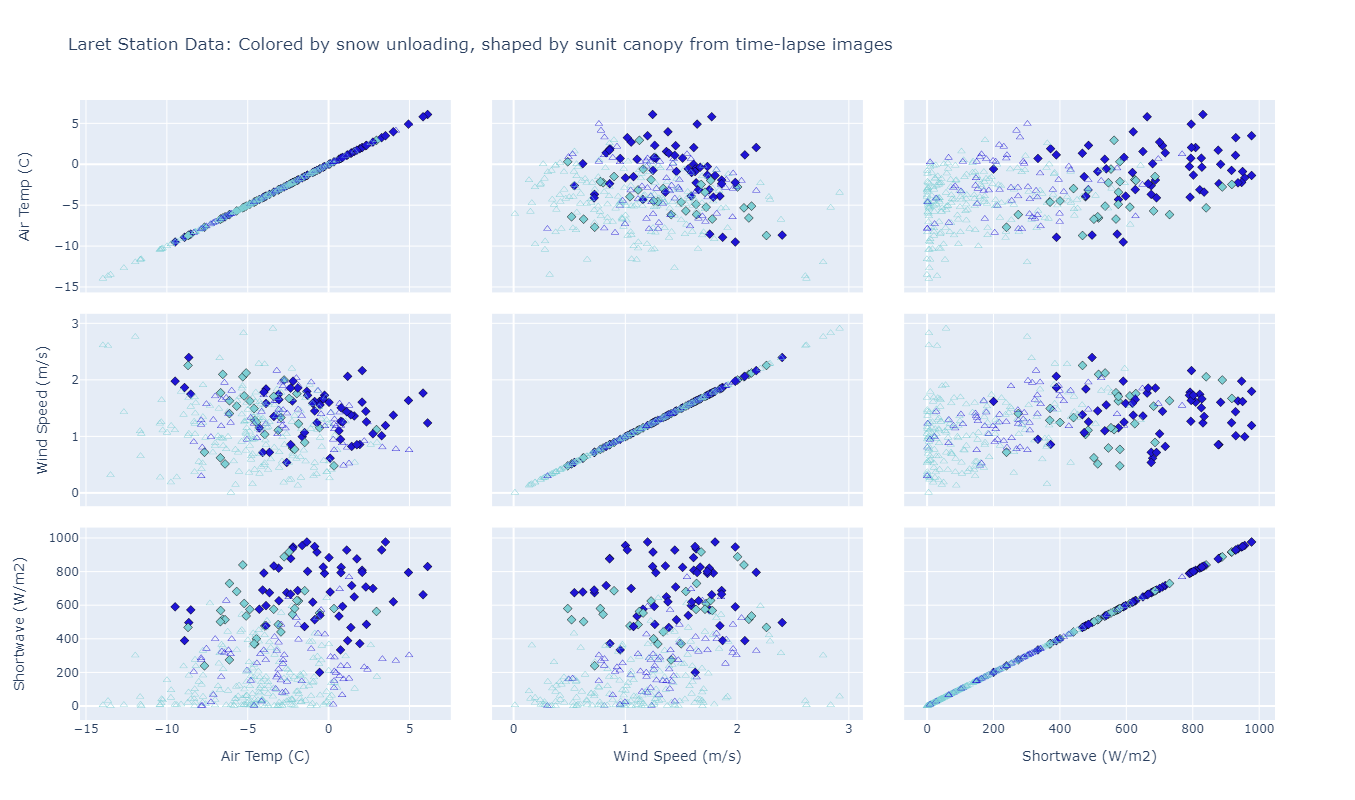

In [69]:
# State which site we are working with 
df = sdf_unload.copy(deep=True)

# Some constatns 
colorscaled = [[0., colorsnowunload], [1, colorsnow]]
# index_vals = df['A'].astype('category').cat.codes
index_vals = df['CD']
index_symbols = df['Esymbol']

fig = go.Figure()
fig.add_trace(go.Splom(dimensions=[dict(label='Air Temp (C)',     values=df['AirTC_Avg']),
                                   dict(label='Wind Speed (m/s)', values=df['WS_ms_Avg']),
                                   dict(label='Shortwave (W/m2)', values=df['SWR_Avg'])],
                                   marker=dict(color=index_vals, colorscale=colorscaled, symbol=index_symbols, showscale=False, line_color='black', line_width=0.5, size=7),
                                   showlegend=False,
                      ))

# Other options
#showupperhalf=False, diagonal_visible=False
#marker=dict(show scale=False)

# fig.update_traces(showlegend=True, legendgroup=index_symbols, selector=dict(mode='spolm'))
# fig.update_traces(showlegend=True)

fig.update_layout(title='Laret Station Data: Colored by snow unloading, shaped by sunit canopy from time-lapse images', width=1000, height=800, dragmode='select')

fig.show()

## open square for cloudy, diamond dot for sunny, open circle for no radiation data